## Using CycleGAN to generate Monet-styled images

<img src= "https://d32dm0rphc51dk.cloudfront.net/95EYpbkhcWsEKG18njyhCw/large.jpg" style='width: 400px;'>

## Problem statement

This is a project about creating & building a GAN (CycleGAN) model, **to generate Monet-styled images from casual photos.**

I chose CycleGAN after multiple failed attemps of training a **DCGAN** model for this problem, where I was trying to modify the loss function to make the training results more consistent.

Unlike problems that include generating a face of people or animal based on multiple good frontal shots of their faces, training a general DCGAN model to create a filter based on **paintings of different landscapes**, provided me with tons of new problems to solve. I tried creating new loss functions that considered **color loss**, but they did not work well.

However, **[CycleGAN](https://junyanz.github.io/CycleGAN/)** is specifically designed for these tasks, by ensuring that the output from the generator can be translated back to the original image, by introducing the **cycle consistency loss.**

There are multiple paintings and photos provided for training, and there are two file formats **(.jpg, .tfrec)** available for each group.

I will use **Keras** library to create / import some models, and optimize & evaluate the model parameters to finalize the submission output.

Code for importing & printing image files was borrowed from **[Amy Jang's public notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)**, and the training pipeline is designed based on this **[official Keras tutorial](https://keras.io/examples/generative/cyclegan/)**. 

## Environment setup & importing data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import keras,os

from keras.models import Sequential, Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from kaggle_datasets import KaggleDatasets

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers

os.system('pip install visualkeras')
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 19.9 MB/s eta 0:00:00


In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
IMAGE_SIZE = (256, 256, 3)
BATCH_SIZE = 1

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCH_SIZE)

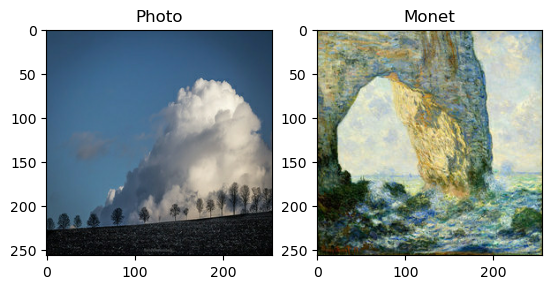

In [5]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Basic EDA

There are **300** paintings of monet provided, along with over **7000** photos to convert.

In the painting, I see more **abstract figures** instead of smooth and sharp edges, plus there's many **detailed contrasts** too. Model layers may need a larger kernel for these paintings.

Also, the **texture and base color palletes** are not the same, so the generator model would have to learn those features also.

Most of them are paintings of nature landscape, and I think that it may be the reason that the photos provided are mostly about landscapes.

## Defining model architecture

The CycleGAN architecture is explained in depth in [this blog post](https://hardikbansal.github.io/CycleGANBlog/).

First, there will be **two generators** that converts photo to monet, and vice versa. There will be **two discriminators** also, that discriminates generated photos and generated monets.

The **adversarial loss** is gained by discriminating on generated images, just like in DCGAN. And in CycleGAN, there are two more losses introduced.

The first one is the **cycle-consistency loss**, which ensures that the generators are consistent and invertible, and this loss is caculated by reconstructing images through two separate generators.

The second one is the **identity loss**, which is used to ensure that the generator does not change the style or contents of the image unnecessarily.

By adding all these three losses, the final loss is gained, then passed onto the gradient calculation section.

## Building blocks for the models

In [6]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def downsample(
    x,
    filters,
    activation,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

## Building the generators

In [7]:
def get_generator(
    filters=64,
    num_downsampling_blocks=3,
    num_upsample_blocks=3,
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init
):
    img_input = layers.Input(shape=IMAGE_SIZE)
    
    x = layers.Conv2D(filters, (6, 6), padding='same', kernel_initializer=kernel_initializer, use_bias=False)(img_input)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)
    
    # Downsampling blocks x 3
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))
        
    # Upsampling blocks x 3
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))
    
    # Final block
    x = layers.Conv2D(3, (6, 6), padding='same', use_bias=False)(x)
    x = layers.Activation("tanh")(x)
    
    model = keras.models.Model(img_input, x)
    
    return model

## Building the discriminators

In [8]:
def get_discriminator(
    filters=64,
    num_downsampling=3,
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
):
    img_input = layers.Input(shape=IMAGE_SIZE)
    
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    # Downsampling blocks x 3
    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x, 
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    # Final block
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same")(x)

    model = keras.models.Model(inputs=img_input, outputs=x)
    
    return model

In [9]:
gen_monet = get_generator()
gen_photo = get_generator()

disc_monet = get_discriminator()
disc_photo = get_discriminator()

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


## Visualizing the models

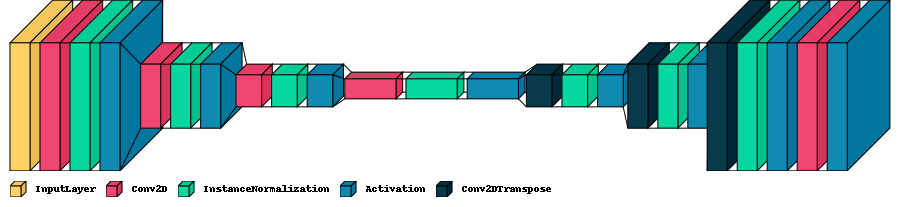

In [10]:
visualkeras.layered_view(gen_monet, legend=True, scale_xy=0.5)

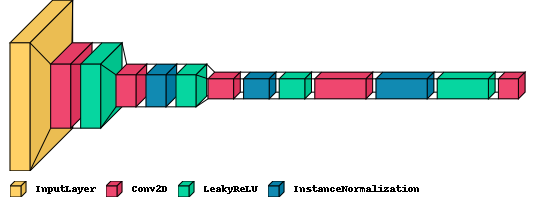

In [11]:
visualkeras.layered_view(disc_monet, legend=True, scale_xy=0.5)

### Examining the visualizations of the models

The generator downsamples the data using **Conv2D**, and upsamples the data again with **Conv2DTranspose** like an autoencoder, hopefully capturing major image features in the process.

There are multiple **InstanceNormalization** layers used, because images in this problem should be considered on a per image basis.

The final output dimension of the generator is same as the input, **(BATCH_SIZE * 256 * 256 * 3)**. This will allow generator to accept raw images.

The discriminator downsamples the data, and reduces the dimension to a single unit with the last Conv2D layer.

## Building the CycleGAN model

In [12]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        gen_monet,
        gen_photo,
        disc_monet,
        disc_photo,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_monet = gen_monet
        self.gen_photo = gen_photo
        self.disc_monet = disc_monet
        self.disc_photo = disc_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_monet_opt,
        gen_photo_opt,
        disc_monet_opt,
        disc_photo_opt,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_monet_opt = gen_monet_opt
        self.gen_photo_opt = gen_photo_opt
        self.disc_monet_opt = disc_monet_opt
        self.disc_photo_opt = disc_photo_opt
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Real photo to fake monet 
            fake_monet = self.gen_monet(real_photo, training=True)
            # Real monet to fake photo
            fake_photo = self.gen_photo(real_monet, training=True)

            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_monet = self.gen_monet(fake_photo, training=True)
            # Cycle (Horse to fake zebra to fake horse) x -> y -> x
            cycled_photo = self.gen_photo(fake_monet, training=True)

            # Identity mapping
            same_monet = self.gen_monet(real_monet, training=True)
            same_photo = self.gen_photo(real_photo, training=True)

            # Discriminator output
            disc_real_monet = self.disc_monet(real_monet, training=True)
            disc_fake_monet = self.disc_monet(fake_monet, training=True)

            disc_real_photo = self.disc_photo(real_photo, training=True)
            disc_fake_photo = self.disc_photo(fake_photo, training=True)

            # Generator adverserial loss
            gen_monet_loss = self.generator_loss_fn(disc_fake_monet)
            gen_photo_loss = self.generator_loss_fn(disc_fake_photo)

            # Generator cycle loss
            cycle_loss_monet = self.cycle_loss_fn(real_monet, cycled_monet) * self.lambda_cycle
            cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo) * self.lambda_cycle

            # Generator identity loss
            id_loss_monet = (
                self.identity_loss_fn(real_monet, same_monet)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_photo = (
                self.identity_loss_fn(real_photo, same_photo)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_monet = gen_monet_loss + cycle_loss_monet + id_loss_monet
            total_loss_photo = gen_photo_loss + cycle_loss_photo + id_loss_photo

            # Discriminator loss
            disc_monet_loss = self.discriminator_loss_fn(disc_real_monet, disc_fake_monet)
            disc_photo_loss = self.discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Get the gradients for the generators
        grads_monet = tape.gradient(total_loss_monet, self.gen_monet.trainable_variables)
        grads_photo = tape.gradient(total_loss_photo, self.gen_photo.trainable_variables)

        # Get the gradients for the discriminators
        disc_monet_grads = tape.gradient(disc_monet_loss, self.disc_monet.trainable_variables)
        disc_photo_grads = tape.gradient(disc_photo_loss, self.disc_photo.trainable_variables)

        # Update the weights of the generators
        self.gen_monet_opt.apply_gradients(
            zip(grads_monet, self.gen_monet.trainable_variables)
        )
        self.gen_photo_opt.apply_gradients(
            zip(grads_photo, self.gen_photo.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_monet_opt.apply_gradients(
            zip(disc_monet_grads, self.disc_monet.trainable_variables)
        )
        self.disc_photo_opt.apply_gradients(
            zip(disc_photo_grads, self.disc_photo.trainable_variables)
        )

        return {
            "monet_loss": total_loss_monet,
            "photo_loss": total_loss_photo,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss,
        }

## Defining base loss functions

In [13]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

## Compiling & training the CycleGAN model

In [14]:
EPOCH_COUNT = 100

In [15]:
model_gan = CycleGAN(
    gen_monet=gen_monet, gen_photo=gen_photo, disc_monet=disc_monet, disc_photo=disc_photo
)

model_gan.compile(
    gen_monet_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_photo_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_monet_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    disc_photo_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

hist = model_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCH_COUNT,
    verbose=0
)

## Evaluating the CycleGAN model

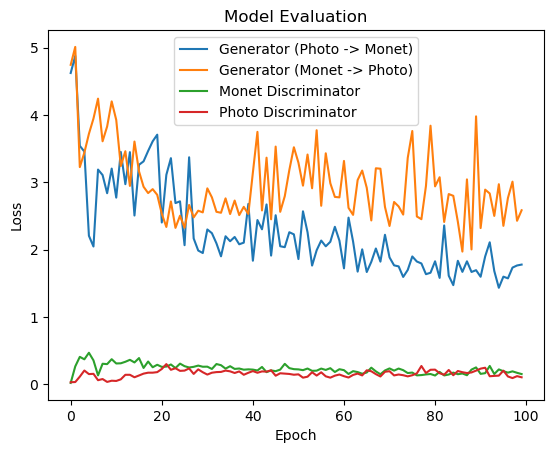

In [16]:
plt.plot(hist.history["monet_loss"])
plt.plot(hist.history['photo_loss'])
plt.plot(hist.history['disc_monet_loss'])
plt.plot(hist.history['disc_photo_loss'])

plt.title("Model Evaluation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Generator (Photo -> Monet)", "Generator (Monet -> Photo)", "Monet Discriminator", "Photo Discriminator"])

plt.show()

### Examining loss plot of the model

The slope oscillates a bit, but the overall trend is consistent. The orange loss of the generator model that converts **paintings into photos** had a larger loss compared to the blue loss of the generator that converts **photos into paintings**, and this may either imply that the latter conversion is easier, or the generator model's architecture is more suited for the latter translation.

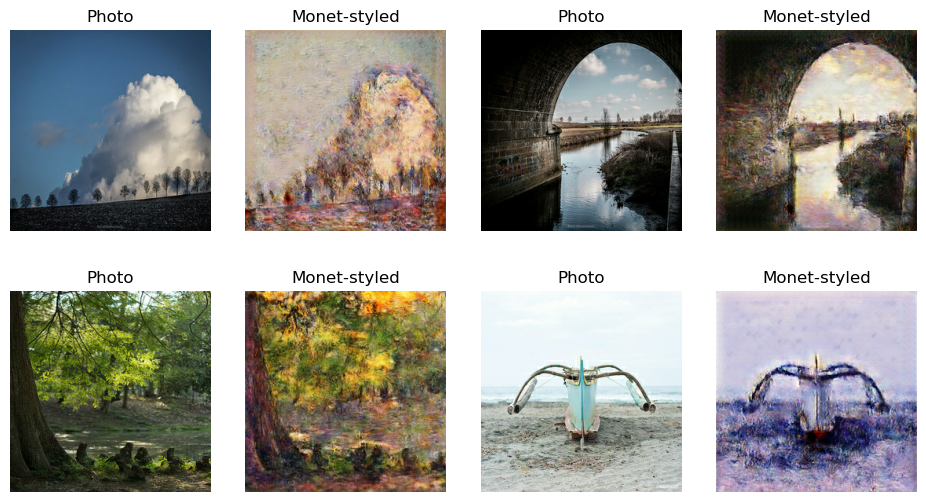

In [17]:
rows, cols = 2, 4

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, photo in enumerate(photo_ds.take(4)):
    monet = gen_monet(photo, training=False)[0].numpy()
    monet = (monet * 127.5 + 127.5).astype(np.uint8)
    photo = (photo[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    row, col = i // 2, i % 2

    axes[row, 2 * col].imshow(photo)
    axes[row, 2 * col].axis('off')
    axes[row, 2 * col].set_title("Photo")
    axes[row, 2 * col + 1].imshow(monet)
    axes[row, 2 * col + 1].axis('off')
    axes[row, 2 * col + 1].set_title("Monet-styled")
    
plt.subplots_adjust(wspace = 0.05, hspace = 0.3)

plt.show()

### Examining translated images

The **colors and the contrasts** of generated images resemble the ones of Monet, and the **texture** of the image also feels like a canvas oil paint.

It looks like the generator models succeeded in capturing major features! Yay!

## Conclusion

**CycleGAN** showed sufficient power in translating images between domains.

Also, the model showed slow, but **more consistent learning speed** compared to traditional GANs, having three different losses being calculated. The more I trained, the better the output became. There was no large-scale oscillations of the generator and discriminator fighting over each other, but the losses still decreased for both models quite consistently.

I am very happy with the results, and plan to use the model architecture for future projects also.

## Submission

In [18]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = gen_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'